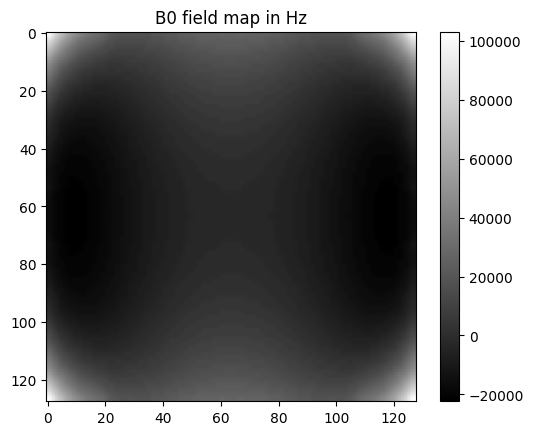

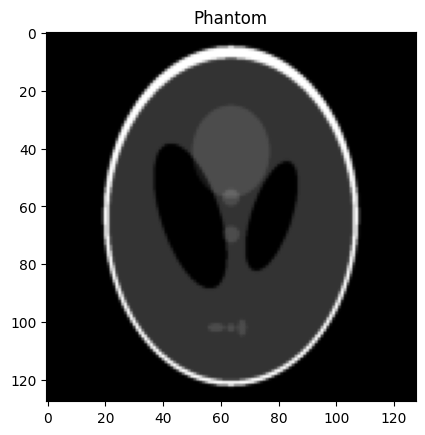

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from tqdm import tqdm

# Re-generate and resize Shepp-Logan phantom
phantom = shepp_logan_phantom()
phantom = resize(phantom, (128, 128))
#phantom /= np.max(phantom)
phantom = phantom.astype(dtype=np.complex128) # Make the phantom complex


N_spins = 128  # Number of spins in the phantom
# # Phantom is a 2D delta function (single point in the center)
# phantom = np.zeros((N_spins, N_spins), dtype=np.complex128)  
# phantom[N_spins//2, N_spins//2] = 1

# Load the B0 field map from the csv file
B0_field_map = pd.read_csv('2Dslice.csv', header=None).values
gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
B0_field_map  = (B0_field_map * gamma)/(2*np.pi * 10000)  # Convert to Hz/T
B0_mean = np.mean(B0_field_map)  # Mean value of the B0 field map
B0_field_map -= np.mean(B0_field_map) # Dividing by the mean value of the B0 field map
B0_field_map *= 2 * np.pi * 5 
B0_field_map = resize(B0_field_map, (128, 128))

B0_test = np.ones((N_spins, N_spins), dtype=np.complex128)

B0_using = B0_field_map

# Plot the B0 field map
plt.title('B0 field map in Hz')
plt.imshow(B0_field_map, cmap='gray')
plt.colorbar()  # Add a color bar to the plot
plt.show()



# Plot the phantom
plt.title('Phantom')
plt.imshow(np.abs(phantom), cmap='gray')
plt.show()



g_mult = 10 # Gradient multiplication factor
Gx = 0.004755753 * g_mult  # Gradient strength in T/m
Gy = 0.004755753 * g_mult # Gradient strength in T/m
B0 = 1.0  # B0 field in T

128it [00:16,  7.90it/s]


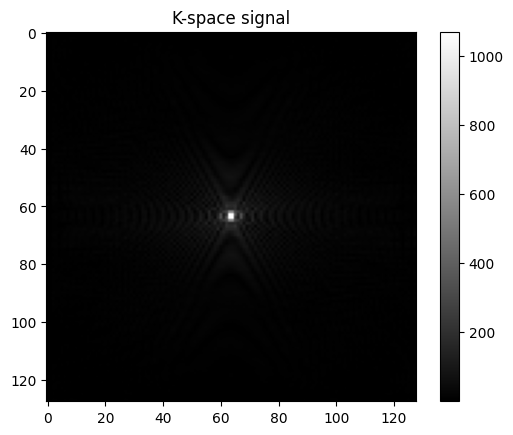

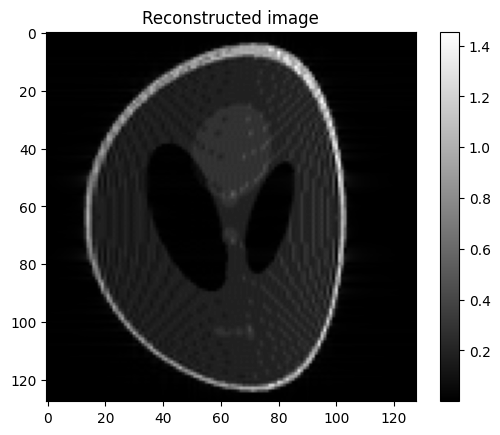

In [13]:
# Time intervals for the gradients
tau = 2e-3
time = np.linspace(-tau/2,tau/2,N_spins)

timey = np.linspace(-tau/2,tau/2,N_spins)

# B0 field inhomogeneities in the x and y directions

# Gradient fields (assuming same for x and y directions)
Gx_values = time * Gx
Gy_values = time * Gx

# k-space trajectory (assuming same for x and y directions)
kx_values = gamma * Gx_values 
ky_values = gamma * Gy_values

# Define field of view
FOV = .2  # meters
x_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
x_values, y_values = np.meshgrid(x_values, y_values, indexing='ij')  # Create 2D coordinate grid


# Compute k-space values
k_space = np.zeros((N_spins, N_spins), dtype=np.complex128)
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values):
        k_space[i, j] = np.sum(phantom * np.exp(-1j * (kx * x_values + ky * y_values)) * np.exp(-1j * B0_using * time[j]))



# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space), cmap='gray')
plt.title('K-space signal')
plt.colorbar()
plt.show()

dwll_time = tau/N_spins

readout_bandwidth =  1/dwll_time


# Apply inverse FFT
reconstructed_image = ifft2(k_space)
reconstructed_image_1 = fftshift(reconstructed_image)

# Plot the reconstructed image
plt.figure()
plt.imshow(np.abs(reconstructed_image_1), cmap='gray')
plt.title('Reconstructed image')
plt.colorbar()
plt.show()

In [14]:
x_values_1 = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values_1 = np.linspace(-FOV / 2, FOV / 2, N_spins)


# def inverse_fourier_2d(k_space):
#     # Allocate a space for the output image
#     image = np.zeros((N_spins, N_spins), dtype=np.complex128)

#     # Create a grid of k-space indices
#     i_values, j_values = np.meshgrid(np.arange(N_spins), np.arange(N_spins), indexing='ij')

#     # Iterate through each pixel in k-space
#     for m in tqdm(range(N_spins)):
#         for n in range(N_spins):
#             # Calculate the inverse Fourier transform using vectorized operations
#             image[m, n] = np.sum(k_space * np.exp(1j * (kx_values[i_values] * x_values_1[m] + ky_values[j_values] * y_values_1[n])) * np.exp(-1j * 2 * np.pi * B0_using * time[n]))

#     return image

# # Apply the inverse Fourier transform to the k-space data
# reconstructed_image = inverse_fourier_2d(k_space)

# # Plot the absolute value of the reconstructed image
# plt.figure()
# plt.imshow(np.abs(reconstructed_image), cmap='gray')
# plt.colorbar()
# plt.title('True Reconstructed Image')
# plt.show()


In [15]:
# Reshape the k-space data into a vector
kspace_vec = np.reshape(k_space, (N_spins*N_spins))

# Initialize a 2D encoding matrix
# encoding_matrix = np.zeros((N_spins**2, N_spins**2), dtype=np.complex128)

# # Iterate over each column in the k_space
# for i in tqdm(range(N_spins)):
#     for j in range(N_spins):  # Additional loop over columns
#         # Generate the 2D encoding matrix for this column
#         for k in range(N_spins):
#             for l in range(N_spins):
#                 # Subtract the phase due to B0 inhomogeneities
#                 phase_correction = 2 * np.pi * B0_field_map * time[j]
#                 Eij = np.exp(-1j * (kx_values[i] * x_values_1[k] + ky_values[j] * y_values_1[l])) * np.exp(-1j * phase_correction)
#                 # Flatten Eij and place it in the corresponding row of the large encoding matrix
#                 encoding_matrix[k*N_spins+l, i*N_spins+j] = Eij # Use i*N_spins+l to index the columns


# # Vectorized version of the encoding matrix. This is equivalent to the above code.
# # Generate 2D arrays for kx_values and ky_values
# kx_2d = kx_values[:, np.newaxis, np.newaxis, np.newaxis]
# ky_2d = ky_values[np.newaxis, :, np.newaxis, np.newaxis]

# # Generate 2D arrays for x_values_1 and y_values_1
# x_2d = x_values_1[np.newaxis, np.newaxis, :, np.newaxis]
# y_2d = y_values_1[np.newaxis, np.newaxis, np.newaxis, :]

# time_2d = time[np.newaxis, np.newaxis, np.newaxis, :]
# B0_field_map_2d = B0_field_map[np.newaxis, np.newaxis, :, :]

# # Compute the phase correction term
# phase_correction_2d = -2 * np.pi * B0_field_map_2d * time_2d

# # Compute Eij for all combinations of indices using broadcasting
# Eij_all = np.exp(-1j * (kx_2d * x_2d + ky_2d * y_2d) + 1j * phase_correction_2d)

# Flatten Eij_all to form the final encoding_matrix
# encoding_matrix = Eij_all.reshape(N_spins**2, N_spins**2)

In [16]:
# x, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = lsqr(encoding_matrix, kspace_vec, iter_lim=200, show=True)
# image = np.reshape(x, (N_spins, N_spins))

In [17]:
# plt.figure()
# plt.imshow(np.abs(image), cmap='gray', vmin=0, vmax=1.0)
# plt.colorbar()
# plt.title('Reconstructed Image')
# plt.show()

In [18]:
E = np.zeros((N_spins**2, N_spins**2), dtype=np.complex128)

# Flatten the arrays to make them 1D
x_values_flat = x_values.flatten()
y_values_flat = y_values.flatten()
B0_field_map_flat = B0_using.flatten()


iterator = 0
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values):
        # Use the flattened arrays in the calculation
        E[:, iterator] = np.exp(-1j * (kx * x_values_flat + ky * y_values_flat)) * np.exp(-1j * B0_field_map_flat * tau)
        iterator += 1

128it [00:30,  4.26it/s]


In [19]:
x_1, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = lsqr(E, kspace_vec, iter_lim=200, show=True)
image_1 = np.reshape(x_1, (N_spins, N_spins))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 16384 rows and 16384 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.811e+03  3.811e+03    1.0e+00  3.3e-02
     1 -4.18203e-02+6.45295e-03j   4.466e+02  4.466e+02    1.2e-01  1.4e+00   1.3e+02  1.0e+00
     2 1.41786e-02+4.01222e-04j   1.480e+02  1.480e+02    3.9e-02  6.6e-01   2.2e+02  2.2e+00
     3 -9.94318e-03+1.62243e-03j   1.210e+02  1.210e+02    3.2e-02  8.7e-02   3.4e+02  3.6e+00
     4 -1.42016e-02+2.14076e-03j   1.198e+02  1.198e+02    3.1e-02  3.2e-02   4.1e+02  4.7e+00
     5 -1.36160e-02+1.85523e-03j   1.194e+02  1.194e+02    3.1e-02  2.6e-02   4.5e+02  6.0e+00
     6 -1.39690e-02+2.75385e-03j   1.187e+02  1.187e+02    3.1e-02  4.9e-02   4.8e+02  9.1e+00
     7 -2.64942e-02-8.18486e-04j   1.

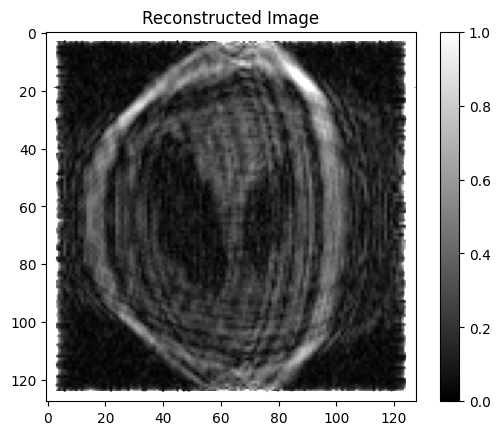

In [20]:
plt.figure()
plt.imshow(np.abs(image_1), cmap='gray', vmin=0, vmax=1.0)
plt.colorbar()
plt.title('Reconstructed Image')
plt.show()

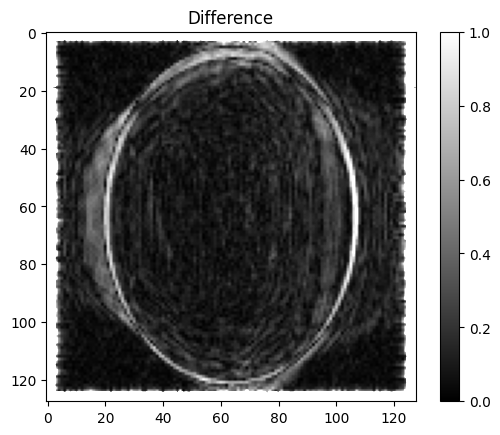

In [21]:
# Make a difference plot of the phantom and the reconstructed image
plt.figure()
plt.imshow(np.abs(phantom - image_1), cmap='gray', vmin=0, vmax=1.0)
plt.colorbar()
plt.title('Difference')
plt.show()

In [22]:
# Finding the average difference between the reconstructed image and the phantom
difference = np.mean(np.abs(phantom - image_1))
difference

2.67809263618497